In [2]:
import os
import cv2
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
from skimage.feature import local_binary_pattern
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

In [3]:
control_image_path = "C:/Users/hp/Ovarian Cancer & Subtypes Detection/archive/OvarianCancer/Non_Cancerous/3.jpg"
if os.path.exists(control_image_path):
    image = cv2.imread(control_image_path)
    if image is not None:
        print("Image successfully loaded.")
    else:
        print("Image could not be loaded.")
else:
    print(f"File does not exist: {control_image_path}")

Image successfully loaded.


In [4]:
# My Process
def apply_gamma_correction_own_function(image, gamma=1.1):
    normalized_image = image / 255.0
    gamma_corrected = normalized_image ** gamma
    gamma_corrected_image = np.array(255 * gamma_corrected, dtype='uint8')
    return gamma_corrected_image

def preprocess_image_with_clahe(image_path):
    global skipped_images_count
    image = cv2.imread(image_path)

    if image is None:
        skipped_images_count += 1
        print("Skipped an image")
        return None

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blurred_image = cv2.GaussianBlur(hsv_image, (3, 3), 0)

    v_channel = blurred_image[:,:,2]

    gamma_corrected_image = apply_gamma_correction_own_function(v_channel, gamma=1.1)

    laplacian_image = cv2.Laplacian(gamma_corrected_image, cv2.CV_64F, ksize=3)
    edges = cv2.Sobel(src=laplacian_image, ddepth=cv2.CV_64F, dx=3, dy=3, ksize=5)

    hsv_image[:,:,2] = cv2.addWeighted(v_channel, 0.7, edges.astype(np.uint8), 0.3, 0)
    processed_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return processed_image

# Actual
def preprocess_cell_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not found.")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)

    kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(edges, kernel, iterations=1)

    result_image = cv2.bitwise_or(image, image, mask=dilated_image)

    return result_image

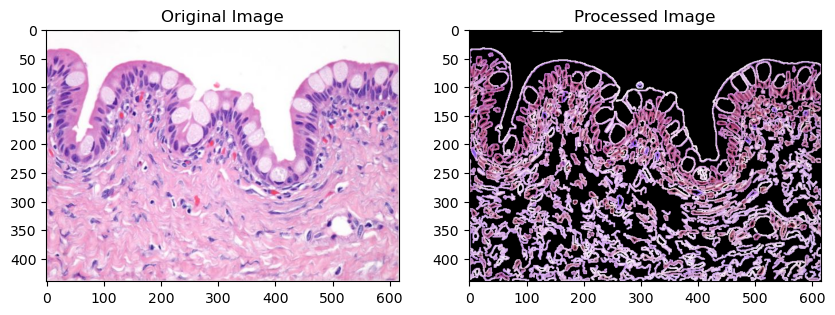

In [5]:
image_path = 'C:/Users/hp/Ovarian Cancer & Subtypes Detection/archive/OvarianCancer/Mucinous/mucinua9.jpg'

processed_image = preprocess_cell_image(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title('Processed Image')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-158.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-603.0..614.0].


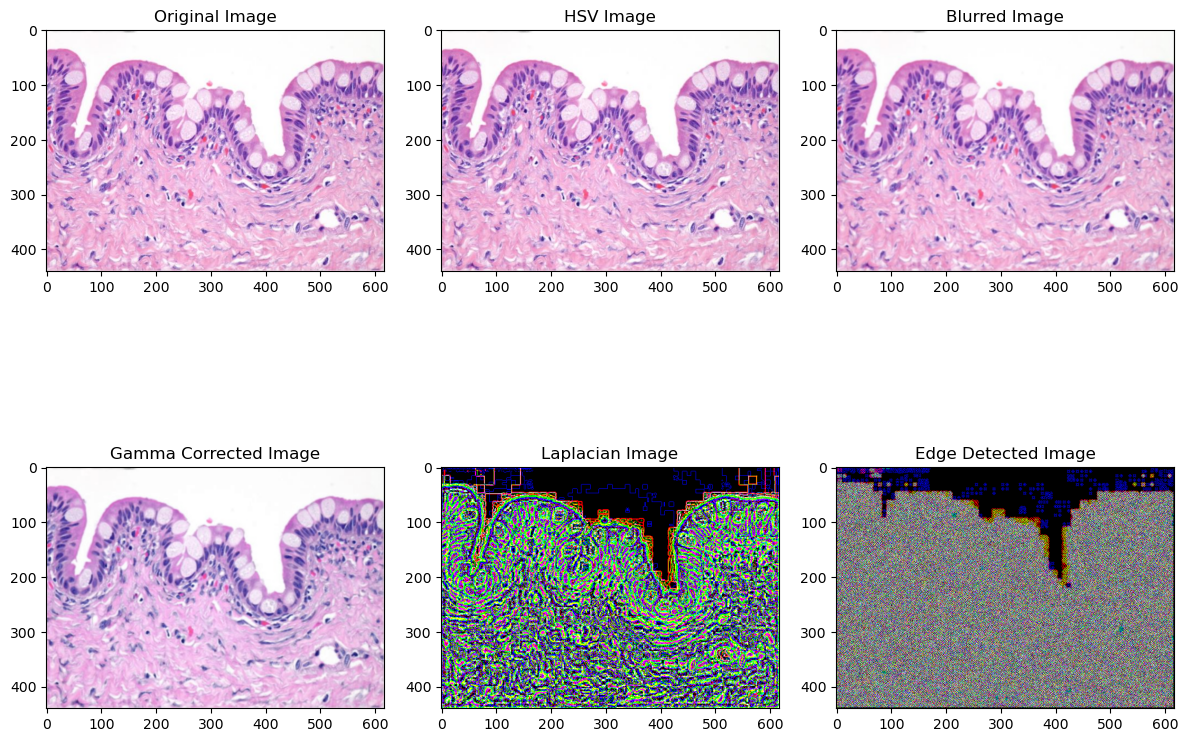

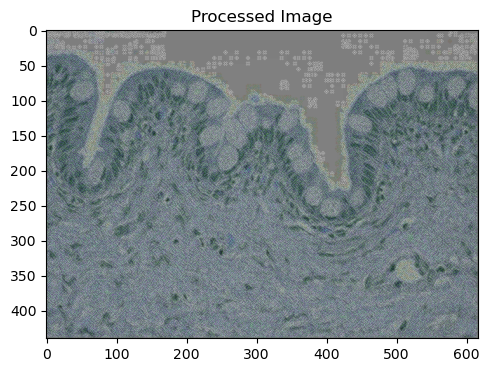

array([[[ 78,   0, 118],
        [ 78,   0, 122],
        [ 78,   0, 126],
        ...,
        [ 33,   0, 124],
        [ 33,   0, 120],
        [ 33,   0, 116]],

       [[ 78,   0, 118],
        [ 78,   0, 124],
        [ 78,   0, 126],
        ...,
        [ 33,   0, 124],
        [ 33,   0, 120],
        [ 33,   0, 116]],

       [[ 78,   0, 118],
        [ 78,   0, 170],
        [130,   0, 126],
        ...,
        [ 33,   0, 124],
        [ 33,   0, 120],
        [ 33,   0, 116]],

       ...,

       [[ 76,   6, 112],
        [123,  49, 114],
        [ 80,   8, 164],
        ...,
        [ 78,  54, 123],
        [120,   6, 116],
        [ 74,   4, 112]],

       [[ 78,   4, 114],
        [ 86,  55, 118],
        [ 79,  10, 121],
        ...,
        [124,  10, 152],
        [ 76,   4, 159],
        [ 72,   2, 111]],

       [[ 80,   4, 114],
        [ 80,   4, 113],
        [ 78,   5, 112],
        ...,
        [ 74,   5, 113],
        [ 71,   2, 112],
        [ 70,   2, 111]]

In [6]:
def visualize_preprocessing_steps(image_path):
    global skipped_images_count
    image = cv2.imread(image_path)
    plt.figure(figsize=(12, 10))

    if image is None:
        skipped_images_count += 1
        print("Skipped an image")
        return None

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB))
    plt.title("HSV Image")

    blurred_image = cv2.GaussianBlur(hsv_image, (3, 3), 0)
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_HSV2RGB))
    plt.title("Blurred Image")

    gamma_corrected_image = apply_gamma_correction_own_function(blurred_image)
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(gamma_corrected_image, cv2.COLOR_HSV2RGB))
    plt.title("Gamma Corrected Image")

    laplacian_image = cv2.Laplacian(gamma_corrected_image, cv2.CV_64F)
    plt.subplot(2, 3, 5)
    plt.imshow(laplacian_image, cmap='gray')
    plt.title("Laplacian Image")

    edges = cv2.Sobel(src=laplacian_image, ddepth=cv2.CV_64F, dx=3, dy=3, ksize=5)
    plt.subplot(2, 3, 6)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detected Image")

    plt.tight_layout()
    plt.show()

    processed_image = cv2.addWeighted(gamma_corrected_image, 0.5, edges.astype(np.uint8), 0.2, 0)
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_HSV2RGB))
    plt.title("Processed Image")
    plt.show()

    return processed_image

image_path_per = 'C:/Users/hp/Ovarian Cancer & Subtypes Detection/archive/OvarianCancer/Mucinous/mucinua9.jpg'
visualize_preprocessing_steps(image_path_per)

## Original Image Loader

In [7]:
class OvarianCancerDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = [
            d for d in os.listdir(root_dir) 
            if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.paths_and_labels = []
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_dir): 
                path = os.path.join(class_dir, file_name)
                if os.path.isfile(path): 
                    if preprocess_cell_image(path) is not None:
                        self.paths_and_labels.append((path, label))
                    else:
                        print(f"Excluding bad image: {path}")

    def __len__(self):
        return len(self.paths_and_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_and_labels[idx]
        image = cv2.imread(image_path)
        if image is None:
            return torch.zeros(3, 224, 224), label
        image = self.transform(image)
        return image, label

def create_datasets(root_dir, train_ratio=0.8):
    dataset = OvarianCancerDataset(root_dir=root_dir)

    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    return train_dataset, val_dataset

In [8]:
data_dir_ovarian_base = "C:/Users/hp/Ovarian Cancer & Subtypes Detection/archive/OvarianCancer"
train_dataset, val_dataset = create_datasets(root_dir=data_dir_ovarian_base)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

## Processed Image Loader

In [9]:
class OvarianCancerDataset(Dataset):
    def __init__(self, root_dir, train=True):
        self.root_dir = root_dir
        self.train = train
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.paths_and_labels = []

        if self.train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256)),
                transforms.RandomCrop((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet veri seti ortalaması ve std
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_dir): 
                path = os.path.join(class_dir, file_name)
                if preprocess_cell_image(path) is not None:
                    self.paths_and_labels.append((path, label))
                else:
                    print(f"Excluding bad image: {path}")

    def __len__(self):
        return len(self.paths_and_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_and_labels[idx]
        image = preprocess_cell_image(image_path)
        if image is None:
            return torch.zeros(3, 224, 224), label
        image = self.transform(image)
        return image, label

def create_datasets(root_dir, train_ratio=0.8):

    dataset = OvarianCancerDataset(root_dir=root_dir, train=True)


    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    val_dataset.dataset = OvarianCancerDataset(root_dir=root_dir, train=False)

    return train_dataset, val_dataset

In [10]:
data_dir_ovarian_base = "C:/Users/hp/Ovarian Cancer & Subtypes Detection/archive/OvarianCancer"
train_dataset, val_dataset = create_datasets(root_dir=data_dir_ovarian_base)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

## CNN Model (Optional)

In [11]:
class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)

        self.dropout_conv = nn.Dropout2d(p=0.3)

        self.pool = nn.MaxPool2d(2, 2)

        # FCL
        self.fc1 = nn.Linear(256 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)

        self.dropout_fc = nn.Dropout(p=0.4)

        self.output = nn.Linear(64, 5)

    def forward(self, x):
        x = self.dropout_conv(F.elu(self.conv1(x)))
        x = self.dropout_conv(F.elu(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv3(x)))
        x = self.dropout_conv(F.elu(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv5(x)))
        x = self.dropout_conv(F.elu(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv7(x)))
        x = self.dropout_conv(F.elu(self.conv8(x)))
        x = self.pool(x)

        x = x.view(-1, 256 * 14 * 14)

        x = self.dropout_fc(F.elu(self.fc1(x)))
        x = self.dropout_fc(F.elu(self.fc2(x)))
        x = self.dropout_fc(F.elu(self.fc3(x)))

        x = self.output(x)
        x = F.log_softmax(x, dim=1)

        return x

In [12]:
class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.dropout_conv = nn.Dropout2d(p=0.2)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 5)
        self.dropout_fc = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout_conv(F.elu(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)

        x = self.dropout_fc(F.elu(self.fc1(x)))
        x = self.dropout_fc(F.elu(self.fc2(x)))

        x = F.log_softmax(x, dim=1)

        return x

In [13]:
model = DCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [14]:
# Trainer for CNN
def train(model, criterion, optimizer, train_loader, val_loader, epochs, train_losses, val_losses, val_accuracies):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

Number of training samples after bad files excluded: 397
Number of validation samples after bad files excluded: 100


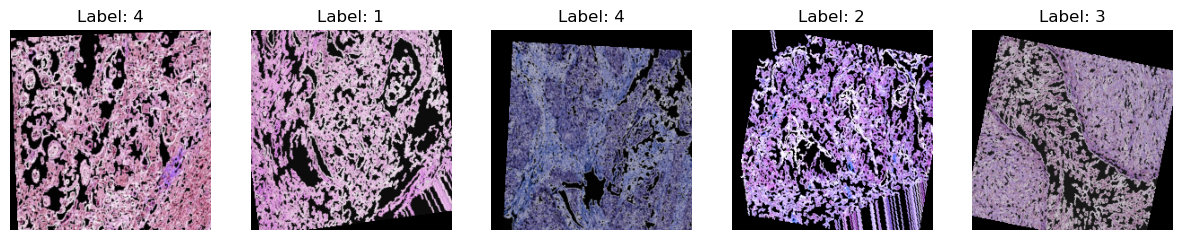

In [15]:
train_dataset, val_dataset = create_datasets(root_dir=data_dir_ovarian_base)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# ---- VISUALIZATION ----
def show_samples(dataset, num_samples=5):
    """Displays a few sample images from the dataset."""
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        # Unnormalize the image if needed (using ImageNet stats).
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)  # Clip to valid range
        axs[i].imshow(img)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    plt.show()

# ---- Usage ----
print(f"Number of training samples after bad files excluded: {len(train_dataset)}")
print(f"Number of validation samples after bad files excluded: {len(val_dataset)}")
show_samples(train_dataset, num_samples=5)


In [16]:
train_losses = []
val_losses = []
val_accuracies = []

# Train CNN
train(model, criterion, optimizer, train_loader, val_loader, epochs=15, train_losses=train_losses, val_losses=val_losses, val_accuracies=val_accuracies)

Epoch 1/15: Train Loss: 1.759, Val Loss: 1.543, Val Accuracy: 23.00%
Epoch 2/15: Train Loss: 1.671, Val Loss: 1.520, Val Accuracy: 35.00%
Epoch 3/15: Train Loss: 1.634, Val Loss: 1.567, Val Accuracy: 32.00%
Epoch 4/15: Train Loss: 1.704, Val Loss: 1.519, Val Accuracy: 36.00%
Epoch 5/15: Train Loss: 1.556, Val Loss: 1.594, Val Accuracy: 34.00%
Epoch 6/15: Train Loss: 1.571, Val Loss: 1.492, Val Accuracy: 36.00%
Epoch 7/15: Train Loss: 1.591, Val Loss: 1.534, Val Accuracy: 31.00%
Epoch 8/15: Train Loss: 1.546, Val Loss: 1.512, Val Accuracy: 36.00%
Epoch 9/15: Train Loss: 1.531, Val Loss: 1.503, Val Accuracy: 40.00%
Epoch 10/15: Train Loss: 1.524, Val Loss: 1.508, Val Accuracy: 36.00%
Epoch 11/15: Train Loss: 1.491, Val Loss: 1.482, Val Accuracy: 43.00%
Epoch 12/15: Train Loss: 1.511, Val Loss: 1.538, Val Accuracy: 37.00%
Epoch 13/15: Train Loss: 1.545, Val Loss: 1.493, Val Accuracy: 33.00%
Epoch 14/15: Train Loss: 1.535, Val Loss: 1.490, Val Accuracy: 38.00%
Epoch 15/15: Train Loss: 1.50

## VGG19 Model

In [17]:
# VGG19
class VGG19FineTuned(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG19FineTuned, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)
        for param in self.vgg19.features.parameters():
            param.requires_grad = False
        self.vgg19.classifier[6] = nn.Linear(self.vgg19.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.vgg19(x)

model = VGG19FineTuned(num_classes=5)

# Optimizer, LOSS L2
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()

C:\Users\hp\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## VGG16 MODEL

In [18]:
class VGG16FineTuned(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16FineTuned, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        self.vgg16.classifier[6] = nn.Linear(self.vgg16.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

model = VGG16FineTuned(num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()

C:\Users\hp\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## VGG13bn MODEL

In [19]:
class VGG13BNFineTuned(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG13BNFineTuned, self).__init__()
        self.vgg13_bn = models.vgg13_bn(pretrained=True)

        for param in self.vgg13_bn.features.parameters():
            param.requires_grad = False

        self.vgg13_bn.classifier[6] = nn.Linear(self.vgg13_bn.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.vgg13_bn(x)

model = VGG13BNFineTuned(num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()

C:\Users\hp\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## VGG Model Train

In [20]:
#VGG Trainer
def train(model, criterion, optimizer, train_loader, val_loader, epochs, train_losses, val_losses, val_accuracies, train_accuracies):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Stopping early at epoch {epoch+1}')
                break

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

In [21]:
#VGG Training
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

epochs = 25
train(model, criterion, optimizer, train_loader, val_loader, epochs, train_losses, val_losses, val_accuracies, train_accuracies)

Epoch 1/25: Train Loss: 1.786, Train Accuracy: 29.22%, Val Loss: 1.739, Val Accuracy: 32.00%
Epoch 2/25: Train Loss: 1.510, Train Accuracy: 41.06%, Val Loss: 1.930, Val Accuracy: 42.00%
Epoch 3/25: Train Loss: 1.345, Train Accuracy: 47.10%, Val Loss: 1.140, Val Accuracy: 57.00%
Epoch 4/25: Train Loss: 1.178, Train Accuracy: 55.67%, Val Loss: 1.029, Val Accuracy: 64.00%
Epoch 5/25: Train Loss: 1.085, Train Accuracy: 61.21%, Val Loss: 1.123, Val Accuracy: 63.00%
Epoch 6/25: Train Loss: 1.105, Train Accuracy: 56.68%, Val Loss: 1.209, Val Accuracy: 72.00%
Epoch 7/25: Train Loss: 0.956, Train Accuracy: 64.23%, Val Loss: 1.245, Val Accuracy: 63.00%
Epoch 8/25: Train Loss: 1.034, Train Accuracy: 58.94%, Val Loss: 1.146, Val Accuracy: 62.00%
Stopping early at epoch 9


## SAVE, RESULT, TEST

In [27]:
def save_model(model, path='C:/Users/hp/Ovarian Cancer & Subtypes Detection/model.pth'):
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# predictor
def predict_random_images(model, dataset, num_images=15):
    model.eval()
    model.to(device)
    images, labels = zip(*[dataset[np.random.randint(len(dataset))] for _ in range(num_images)])
    images = torch.stack(images).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    return images.cpu(), predictions.cpu(), labels

def evaluate_predictions(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = len(predictions)
    wrong = total - correct
    print(f'Total images: {total}, Correct predictions: {correct}, Wrong predictions: {wrong}')
    return correct, wrong

def get_model_predictions_for_roc(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_roc_curve(true_labels, model_preds, num_classes):
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):

        labels = (true_labels == i)
        preds = model_preds[:, i]

        fpr, tpr, _ = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='Class %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def get_confusion_matrix(true_labels, model_preds):
    pred_labels = np.argmax(model_preds, axis=1)
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

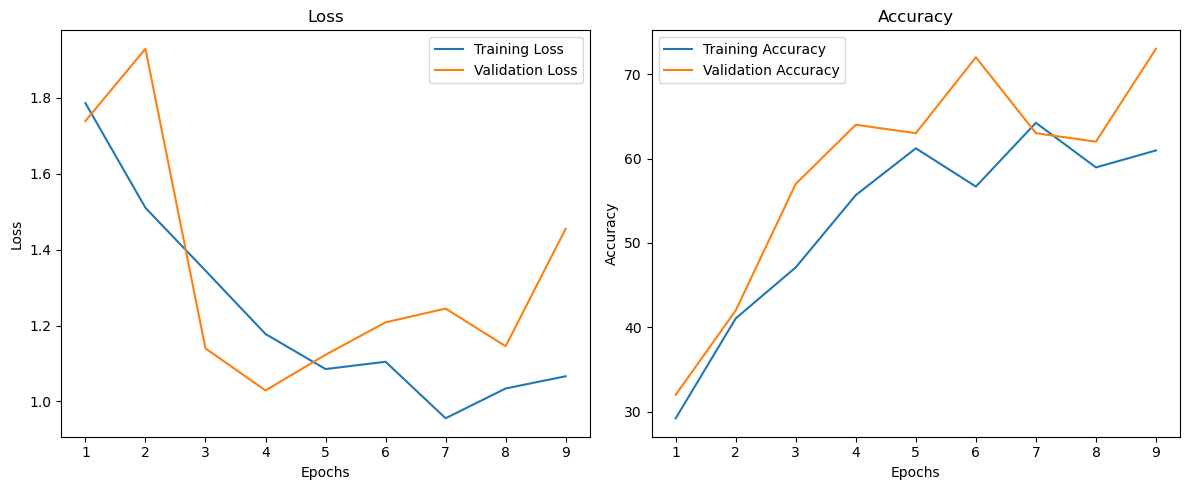

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Total images: 15, Correct predictions: 13, Wrong predictions: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Cli

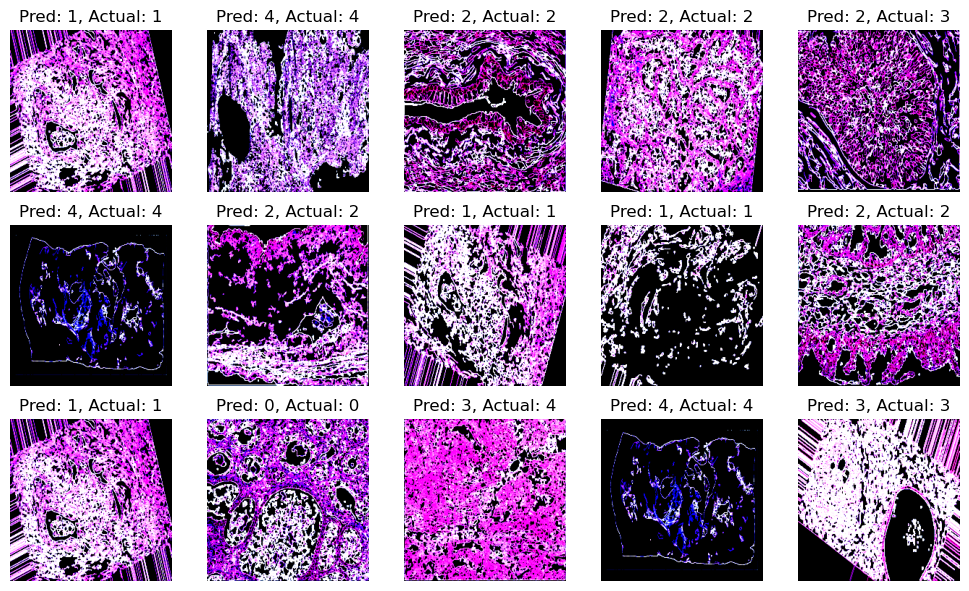

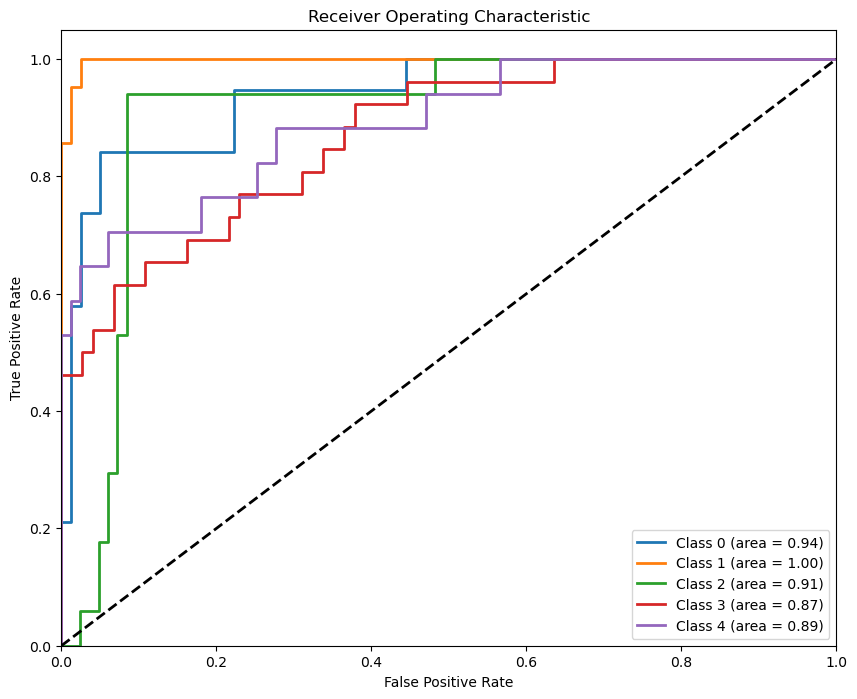

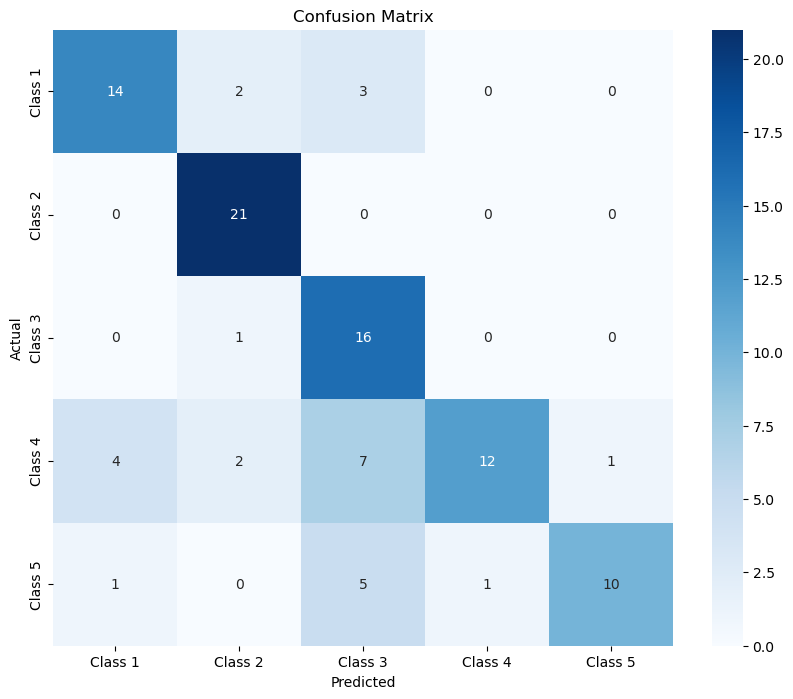

In [23]:
save_model(model, 'C:/Users/hp/Ovarian Cancer & Subtypes Detection/vgg19_finetuned_best.pth')

plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Random 15 image
images, predictions, labels = predict_random_images(model, val_dataset, num_images=15)
correct, wrong = evaluate_predictions(predictions, torch.tensor(labels))

num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for ax in axes.flatten()[len(images):]:
    ax.axis('off')

for i, ax in enumerate(axes.flatten()):
    if i >= len(images):
        break
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f'Pred: {predictions[i]}, Actual: {labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

model_preds, true_labels = get_model_predictions_for_roc(model, val_loader, device)
plot_roc_curve(true_labels, model_preds, num_classes=5)

# Confusion matrix
cm = get_confusion_matrix(true_labels, model_preds)
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
plot_confusion_matrix(cm, class_names)

In [28]:
torch.save(model.state_dict(), 'model_weights.pth')